# Part1. model building and training

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, SGD


In [ ]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

In [ ]:
# relevant file path
PROJECT_FOLDER = '/content/gdrive/MyDrive/PythonWork_Learning/Lazy_programmer/Deep-Learning-in-Python/'
CORPUS = os.path.join(PROJECT_FOLDER, 'rnn_class','robert_frost.txt')
GLOVE_FILE = os.path.join(PROJECT_FOLDER, 'large_files', 'glove.6B', f'glove.6B.{EMBEDDING_DIM}d.txt')
PROJECT_PATH = os.path.join(PROJECT_FOLDER, 'nlp_class3')

In [ ]:
# load in the data
input_texts = []
target_texts = []
for line in open(CORPUS):
  line = line.rstrip()    # 這裡並沒有移除標點符號，之後可以加入這個想法嘗試看看
  if not line:
    continue

  input_line = '<sos> ' + line
  target_line = line + ' <eos>'

  input_texts.append(input_line)
  target_texts.append(target_line)


all_lines = input_texts + target_texts

In [ ]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='') # filters='' 的原因是，若不這樣做，這支程式預設會過濾掉許多特殊符號，那 < > 就會被過濾掉了
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [ ]:
# find max seq length
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('Max sequence length:', max_sequence_length_from_data)

Max sequence length: 12


In [ ]:
# get word -> integer mapping
word2idx = tokenizer.word_index # idx 從1 開始，因為keras 會將idx= 0 留給 padding
print(f'Found {len(word2idx)} unique tokens')
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 3056 unique tokens


In [ ]:
# pad sequences so that we get a N x T matrix
max_sequence_length = min(max_sequence_length_from_data, MAX_SEQUENCE_LENGTH) # 這裡算出建模時需要的 sequence_length (T)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post') # 會把 list 轉成 np.array
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print('Shape of data tensor:', input_sequences.shape)

Shape of data tensor: (1436, 12)


In [ ]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(GLOVE_FILE) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [ ]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < num_words:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [ ]:
# one-hot the targets (can't use sparse cross-entropy)
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
  for t, word in enumerate(target_sequence):
    if word > 0:
      one_hot_targets[i, t, word] = 1

In [ ]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(
    num_words, 
    EMBEDDING_DIM, 
    weights=[embedding_matrix], 
    # trainable=False
)

In [ ]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(max_sequence_length,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don't need the states here
dense = Dense(num_words, activation='softmax')
output = dense(x)

# 講師這裡把每一個layer物件 都指派給一個變數的原因是, 
# 之後預測階段要利用同一個物件，以及其內部訓練過的參數
# 我的習慣是會把參數存出來，之後重新建一個一樣架構的模型，再載入參數

model = Model([input_, initial_h, initial_c], output)

Building model...


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             150000      input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 25)]         0                                            
______________________________________________________________________________________________

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  # optimizer='rmsprop',
  optimizer=Adam(lr=0.01),
  # optimizer=SGD(lr=0.01, momentum=0.9),
  metrics=['accuracy']
)


In [ ]:
z = np.zeros((len(input_sequences), LATENT_DIM)) # 注意，input_sequences 有幾個，就創造幾個 hidden state (cell state)，對RNN丟入一組 Batch size＝Ｎ的訓練資料，就要同時丟入一組 Batch Size=N 的 hiddent state，才能做訓練 
print('shape of input data format')
print('input_sequences.shape: ', input_sequences.shape)
print('z.shape: ', z.shape)
print("one_hot_targets.shape: ", one_hot_targets.shape)

shape of input data format
input_sequences.shape:  (1436, 12)
z.shape:  (1436, 25)
one_hot_targets.shape:  (1436, 12, 3000)


In [ ]:
print('Training model...')
r = model.fit(
  [input_sequences, z, z],
  one_hot_targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

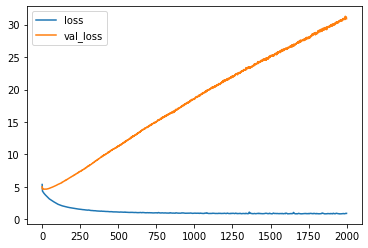

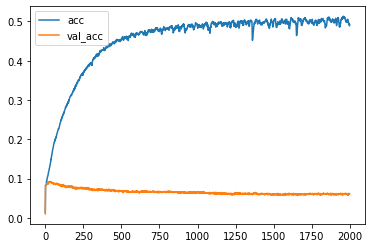

In [ ]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
# # Save model
# model.save('s2s.h5') 

## 嘗試使用 tf.data.Dataset 型別（自己測試出來的寫法）

### loss function 使用 CategoricalCrossentropy()
- 代表target 要是 one-hot representation

In [ ]:
z = np.zeros((len(input_sequences), LATENT_DIM)) # 注意，input_sequences 有N個，就創造N個 hidden state (cell state)，對RNN丟入一組 Batch size＝Ｎ的訓練資料，就要同時丟入一組 Batch Size=N 的 hiddent state，才能做訓練 
print('shape of input data format')
print('input_sequences.shape: ', input_sequences.shape)
print('z.shape: ', z.shape)
print("one_hot_targets.shape: ", one_hot_targets.shape)

shape of input data format
input_sequences.shape:  (1436, 12)
z.shape:  (1436, 25)
one_hot_targets.shape:  (1436, 12, 3000)


In [ ]:
# data pipline
def get_training_dataset():
  def generater():
    for s_, z_, z_, t_ in zip(input_sequences, z, z, one_hot_targets):
      yield {"input_1": s_,'input_2': z_, "input_3": z_, }, t_

  dataset = tf.data.Dataset.from_generator(
      generater, 
      output_types=({"input_1":tf.int32, 
                    "input_2":tf.int32, 
                      "input_3":tf.int32}, 
                    tf.int32))
  return dataset.batch(BATCH_SIZE)

In [ ]:
# next(iter(get_training_dataset()))

In [ ]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(max_sequence_length,), name='input_1')
initial_h = Input(shape=(LATENT_DIM,), name="input_2")
initial_c = Input(shape=(LATENT_DIM,), name="input_3")
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don't need the states here
dense = Dense(num_words, activation='softmax')
output = dense(x)
model = Model([input_, initial_h, initial_c], output)

Building model...


In [ ]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             150000      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 25)]         0                                            
___________________________________________________________________________________________

In [ ]:
model.compile(
  # loss='categorical_crossentropy',
  loss=tf.keras.losses.CategoricalCrossentropy(),
  # optimizer='rmsprop',
  optimizer=Adam(lr=0.01),
  # optimizer=SGD(lr=0.01, momentum=0.9),
  metrics=[tf.keras.metrics.CategoricalAccuracy()] # 使用 tf.data.Dataset 型別時，metrics 要使用tf.keras.metrics 底下的class 才不會報錯
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
callbacks = [
  tf.keras.callbacks.ModelCheckpoint(
      filepath=os.path.join(PROJECT_PATH, 'poetry_model.h5'), 
      save_weights_only=True,
      monitor='loss', 
  )
]

In [ ]:
%%time
r = model.fit(
    get_training_dataset(), 
    epochs=EPOCHS,
    callbacks=callbacks
)

### loss function 使用 sparse_categorical_crossentropy()
- 代表target 可以用 index 表示，不需要轉成one-hot representation 就可以計算loss

In [ ]:
def get_training_dataset():
  def generator():
    for s_, z_, z_, t_ in zip(input_sequences, z, z, target_sequences):
      yield {'input_1':s_, 'input_2': z_, 'input_3': z_, }, t_

  dataset = tf.data.Dataset.from_generator(
      generator, 
      output_types=({"input_1": tf.int32,
                     "input_2": tf.int32, 
                     "input_3": tf.int32}, 
                    tf.int32)
  )
  return dataset.batch(BATCH_SIZE)

In [ ]:
# next(iter(get_training_dataset()))

In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    optimizer=Adam(lr=0.01),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
callbacks = [
  tf.keras.callbacks.ModelCheckpoint(
      filepath=os.path.join(PROJECT_PATH, 'poetry_model.h5'), 
      save_weights_only=True,
      monitor='loss', 
  )
]

In [ ]:
r = model.fit(
    get_training_dataset(), 
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/5
12/12 [==============================] - 3s 58ms/step - loss: 6.4790 - sparse_categorical_accuracy: 0.1132
Epoch 2/5
12/12 [==============================] - 1s 57ms/step - loss: 5.5909 - sparse_categorical_accuracy: 0.1153
Epoch 3/5
12/12 [==============================] - 1s 57ms/step - loss: 5.0550 - sparse_categorical_accuracy: 0.2770
Epoch 4/5
12/12 [==============================] - 1s 58ms/step - loss: 4.2651 - sparse_categorical_accuracy: 0.4118
Epoch 5/5
12/12 [==============================] - 1s 57ms/step - loss: 3.4873 - sparse_categorical_accuracy: 0.4291


# Part2. make a sampling model

### rebuild model

In [ ]:
# make a sampling model 重新建立一個預測階段用的模型
input2 = Input(shape=(1, )) # we'll only input one word at a time
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # 這裡我們就需要擷取模型輸出的 hidden state and cell state, 因為要拿來做下一個輸入
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])

sampling_model.load_weights(os.path.join(PROJECT_PATH, 'poetry_model.h5')) # 預測階段的模型，跟訓練階段的模型架構一樣，直接載入權重且拿來用，但是seq2seq就不是這樣子喔

# sampling_model.summary()

In [ ]:
# reverse word2idx dictionary to get back words
# during prediction
idx2word = {v:k for k, v in word2idx.items()}

In [ ]:
def sample_line():
  #initial inputs
  np_inputs = np.array([[word2idx['<sos>']]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))
 
  # so we know when to quit
  eos = word2idx['<eos>']

  # store the output here
  output_sentence = []

  for _ in range(max_sequence_length):
    o, h, c = sampling_model.predict([np_inputs, h, c])

    # print("o.shape:", o.shape, o[0,0,:10])
    # idx = np.argmax(o[0,0])
    probs = o[0, 0]
    if np.argmax(probs) == 0:   # index=0 代表 padding，若發生這個情況，則不合理，要避免掉
      print('wtf')
    probs[0] = 0  # padding 出線的機率直接訂為0，讓他無法被np.random.choice 出來
    probs /= probs.sum() #因為做了上面一步，這裡重新對所有機率歸一
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break

    # accuulate output
    output_sentence.append(idx2word.get(idx, f'<WTF {idx}>'))

      # make the next input into model
    np_inputs[0,0] = idx

  return " ".join(output_sentence)
    

In [ ]:
# generate a 4 line poem
while True:
  for _ in range(4):
    print(sample_line())

  ans = input("---generate another? [Y/n]---")
  if ans and ans[0].lower().startswith('n'):
    break


the situation was like this: this time from chases, lowes, and baileys,
of the stark family i'm a member of.'
this eden day is done at least to look,
i could see nothing. all.
---generate another? [Y/n]---y
lifted his
to call it day
that there always is on the papered walls,
to break it to him.
---generate another? [Y/n]---Y
what well may prove the year's high
what you have to remind me
a governor it was proclaimed he inquired. 'no matter for the proof.'
wants to hear your you-
---generate another? [Y/n]---k
if i looked always the same,
to such a ghost—
he did there a witch. i live
i'll tell you what the voices do him everything,
---generate another? [Y/n]---n
